In [ ]:
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-geometric

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 70.1 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.4 MB/s eta 0:00:00


In [5]:
import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [15]:
file_path = '/content/drive/MyDrive/data_object.pt'
data = torch.load(file_path)

<ipython-input-15-9bb635bcab3b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


In [26]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(166, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 3)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(166, 16)
  (conv2): GCNConv(16, 3)
)


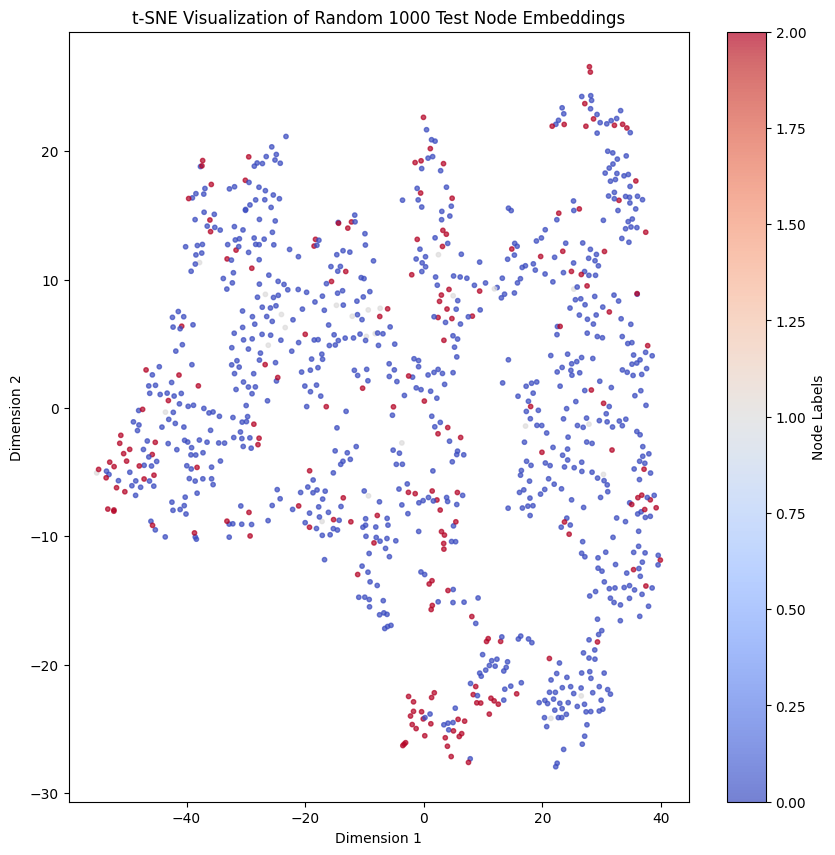

In [27]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

model.eval()
out = model(data.x, data.edge_index)

# t-SNE embeddings before training
test_indices = torch.nonzero(data.test_mask, as_tuple=True)[0]
num_samples = min(1000, len(test_indices))
random_indices = np.random.choice(test_indices, num_samples, replace=False)
random_test_embeddings = out[random_indices].cpu().detach().numpy()
random_test_labels = data.y[random_indices].cpu().numpy()
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(random_test_embeddings)
plt.figure(figsize=(10, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=random_test_labels, cmap='coolwarm', s=10, alpha=0.7)
plt.colorbar(scatter, label="Node Labels")
plt.title("t-SNE Visualization of Random 1000 Test Node Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [19]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 3.2391
Epoch: 002, Loss: 2.2249
Epoch: 003, Loss: 1.6697
Epoch: 004, Loss: 1.4656
Epoch: 005, Loss: 1.4201
Epoch: 006, Loss: 1.4141
Epoch: 007, Loss: 1.3783
Epoch: 008, Loss: 1.3285
Epoch: 009, Loss: 1.2683
Epoch: 010, Loss: 1.1874
Epoch: 011, Loss: 1.1342
Epoch: 012, Loss: 1.0749
Epoch: 013, Loss: 1.0114
Epoch: 014, Loss: 0.9597
Epoch: 015, Loss: 0.9030
Epoch: 016, Loss: 0.8600
Epoch: 017, Loss: 0.8084
Epoch: 018, Loss: 0.7651
Epoch: 019, Loss: 0.7303
Epoch: 020, Loss: 0.7078
Epoch: 021, Loss: 0.6825
Epoch: 022, Loss: 0.6636
Epoch: 023, Loss: 0.6509
Epoch: 024, Loss: 0.6435
Epoch: 025, Loss: 0.6313
Epoch: 026, Loss: 0.6266
Epoch: 027, Loss: 0.6192
Epoch: 028, Loss: 0.6130
Epoch: 029, Loss: 0.6077
Epoch: 030, Loss: 0.6035
Epoch: 031, Loss: 0.5973
Epoch: 032, Loss: 0.5929
Epoch: 033, Loss: 0.5916
Epoch: 034, Loss: 0.5841
Epoch: 035, Loss: 0.5810
Epoch: 036, Loss: 0.5777
Epoch: 037, Loss: 0.5715
Epoch: 038, Loss: 0.5681
Epoch: 039, Loss: 0.5627
Epoch: 040, Loss: 0.5605


In [20]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8296


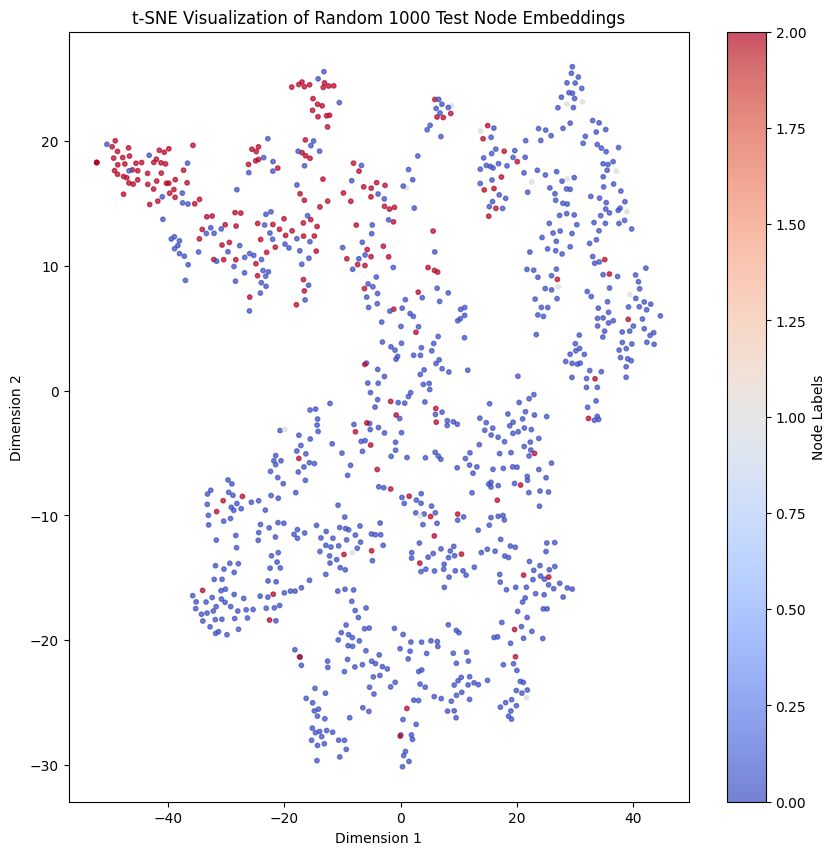

In [25]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

model.eval()
out = model(data.x, data.edge_index)

# t-SNE embeddings after training
test_indices = torch.nonzero(data.test_mask, as_tuple=True)[0]
num_samples = min(1000, len(test_indices))  # Ensure you don't select more than available
random_indices = np.random.choice(test_indices, num_samples, replace=False)
random_test_embeddings = out[random_indices].cpu().detach().numpy()
random_test_labels = data.y[random_indices].cpu().numpy()
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(random_test_embeddings)
plt.figure(figsize=(10, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=random_test_labels, cmap='coolwarm', s=10, alpha=0.7)
plt.colorbar(scatter, label="Node Labels")
plt.title("t-SNE Visualization of Random 1000 Test Node Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()